In [29]:
import os
import argparse
from tqdm import tqdm
from common_utils import *
from GameFormer.data_utils import *
import matplotlib.pyplot as plt
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping

In [30]:
data_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/data/cache/train_boston'
map_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/maps'
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
debug = False
map_version = "nuplan-maps-v1.0"
sensor_root = None
db_files = None


In [31]:
scenario_mapping = ScenarioMapping(scenario_map=get_scenario_map(), subsample_ratio_override=0.5)
builder = NuPlanScenarioBuilder(data_path, map_path, sensor_root, db_files, map_version, scenario_mapping=scenario_mapping)

scenario_filter = ScenarioFilter(*get_filter_parameters(scenarios_per_type, total_scenarios, shuffle_scenarios))
worker = SingleMachineParallelExecutor(use_process_pool=True)
scenarios = builder.get_scenarios(scenario_filter, worker)
print(f"Total number of scenarios: {len(scenarios)}")


Total number of scenarios: 10777


In [32]:
scenarios[0].log_name

'2021.09.17.13.47.10_veh-28_01155_01549'

In [33]:
past_time_horizon = 2 # [seconds]
num_past_poses = 10 * past_time_horizon 
future_time_horizon = 8 # [seconds]
num_future_poses = 10 * future_time_horizon
num_agents = 20

_map_features = ['LANE', 'ROUTE_LANES', 'CROSSWALK'] # name of map features to be extracted.
_max_elements = {'LANE': 40, 'ROUTE_LANES': 10, 'CROSSWALK': 5} # maximum number of elements to extract per feature layer.
_max_points = {'LANE': 50, 'ROUTE_LANES': 50, 'CROSSWALK': 30} # maximum number of points per feature to extract per feature layer.
_radius = 60 # [m] query radius scope relative to the current pose.
_interpolation_method = 'linear' # Interpolation method to apply when interpolating to maintain fixed size map elements.


In [34]:
idx = 0
scenario = scenarios[idx]
# nuplan/nuplan-devkit/nuplan/planning/scenario_builder/nuplan_db/nuplan_scenario.py
map_name = scenario._map_name
token = scenario.token
map_api = scenario.map_api 
log_name = scenario.log_name
print(f"Scenario: {scenario}")
print(f"Map name: {map_name}")
print(f"Scenario token: {token}")
print(f"Map API: {map_api}")

Scenario: <nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario.NuPlanScenario object at 0x7f5d8d4d3a00>
Map name: us-ma-boston
Scenario token: 0008836f94845f11
Map API: <nuplan.common.maps.nuplan_map.nuplan_map.NuPlanMap object at 0x7f5dc05fff40>


### get agent past tracks

torch.Size([21, 7])
torch.Size([21])


(332657.309375, 332675.253125, 4690047.475, 4690048.025)

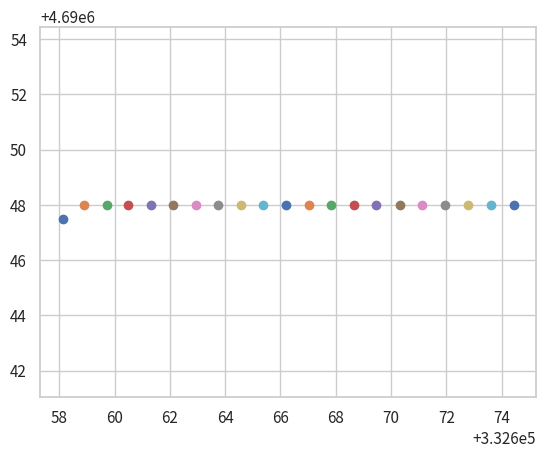

In [35]:
def get_ego_agent():
    anchor_ego_state = scenario.initial_ego_state
    
    past_ego_states = scenario.get_ego_past_trajectory(
        iteration=0, num_samples=num_past_poses, time_horizon=past_time_horizon
    )
    
    sampled_past_ego_states = list(past_ego_states) + [anchor_ego_state]
    past_ego_states_tensor = sampled_past_ego_states_to_tensor(sampled_past_ego_states)

    past_time_stamps = list(
        scenario.get_past_timestamps(
            iteration=0, num_samples=num_past_poses, time_horizon=past_time_horizon
        )
    ) + [scenario.start_time]

    past_time_stamps_tensor = sampled_past_timestamps_to_tensor(past_time_stamps)

    return past_ego_states_tensor, past_time_stamps_tensor

# get agent past tracks
ego_agent_past, time_stamps_past = get_ego_agent()
print(ego_agent_past.shape)   # shape = (N, 7) = (x, y, heading, vx, vy, ax, ay)
print(time_stamps_past.shape)
for i in range(len(ego_agent_past)):
    if ego_agent_past[i, 0] == 0 or ego_agent_past[i, 1] == 0:
        continue
    plt.scatter(ego_agent_past[i, 0], ego_agent_past[i, 1])
plt.axis('equal')
# print(ego_agent_past[:, 1])

21
torch.Size([29, 8])
21
29
torch.Size([32, 8])


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

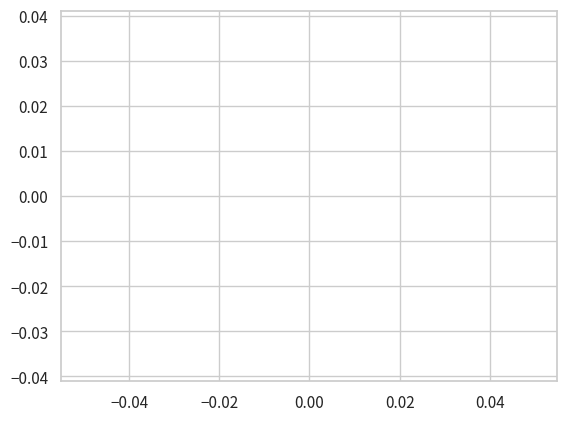

In [36]:

def get_neighbor_agents():
    present_tracked_objects = scenario.initial_tracked_objects.tracked_objects
    past_tracked_objects = [
        tracked_objects.tracked_objects
        for tracked_objects in scenario.get_past_tracked_objects(
            iteration=0, time_horizon=past_time_horizon, num_samples=num_past_poses
        )
    ]

    sampled_past_observations = past_tracked_objects + [present_tracked_objects]
    past_tracked_objects_tensor_list, past_tracked_objects_types = \
            sampled_tracked_objects_to_tensor_list(sampled_past_observations)

    return past_tracked_objects_tensor_list, past_tracked_objects_types

neighbor_agents_past, neighbor_agents_types = get_neighbor_agents()

print(len(neighbor_agents_past))    # length = T
print(neighbor_agents_past[0].shape)   # shape = (N_other, 8) = (idx, vx, vy, heading, weight, height, x, y)
print(len(neighbor_agents_types))  # length = N
print(len(neighbor_agents_types[0]))   

i = 10
traj = neighbor_agents_past[i]  # batch = 1
print(traj.shape)
# plt.scatter(traj[:, 6], traj[:, 7])
# plt.scatter(ego_agent_past[i, 0], ego_agent_past[i, 1])
plt.axis('equal') 

In [37]:
# 只能运行一次
ego_agent_past, neighbor_agents_past, neighbor_indices = \
    agent_past_process(ego_agent_past, time_stamps_past, neighbor_agents_past, neighbor_agents_types, num_agents)


(21, 7)
(20, 21, 11)
20
[14, 10, 6, 12, 2, 30, 1, 15, 11, 5, 4, 16, 3, 8, 17, 0, 20, 21, 23, 7]


(-50.606333541870114,
 50.94893913269043,
 -25.09824686050415,
 22.636662769317628)

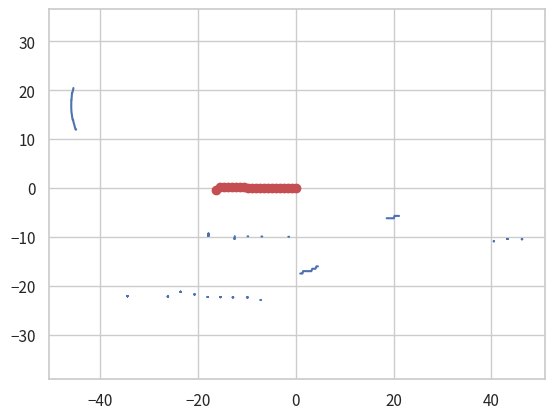

In [38]:
print(ego_agent_past.shape)   # shape = (21, 7), Th = 21
print(neighbor_agents_past.shape)   # shape = (20, 21, 11)
print(len(neighbor_indices))  # 周车的数量 <= 20
print(neighbor_indices)

for i in range(len(ego_agent_past)):
    plt.scatter(ego_agent_past[i][0], ego_agent_past[i][1], c='r')
    
for j in range(20):
    traj = neighbor_agents_past[j]
    # print(traj[0][0])
    if traj[0][0] == 0 or traj[0][1] == 0:
        continue
    plt.plot(traj[:, 0], traj[:, 1], 'b')
        
plt.axis('equal')

### get vector set map

In [39]:
def get_map():        
    ego_state = scenario.initial_ego_state
    ego_coords = Point2D(ego_state.rear_axle.x, ego_state.rear_axle.y)
    route_roadblock_ids = scenario.get_route_roadblock_ids()
    traffic_light_data = scenario.get_traffic_light_status_at_iteration(0)

    coords, traffic_light_data = get_neighbor_vector_set_map(
        map_api, _map_features, ego_coords, _radius, route_roadblock_ids, traffic_light_data
    )
    
    vector_map = map_process(ego_state.rear_axle, coords, traffic_light_data, _map_features, 
                                _max_elements, _max_points, _interpolation_method)

    return vector_map
    
vector_map = get_map()

In [40]:
vector_map.keys()
print(vector_map['lanes'].shape) # shape = (40, 50, 2)
print(vector_map['route_lanes'].shape) # shape = (10, 50, 2)
print(vector_map['crosswalks'].shape) # shape = (5, 30, 2)

(40, 50, 7)
(10, 50, 3)
(5, 30, 3)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


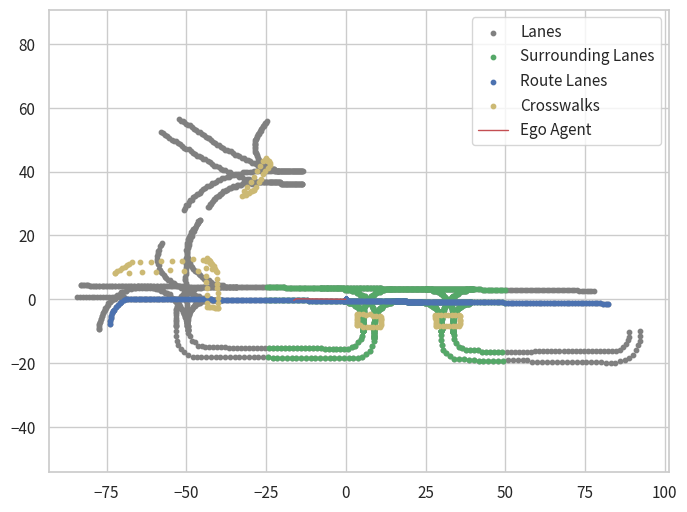

In [41]:
import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(8, 6))

# 绘制 lanes
for i in range(len(vector_map['lanes'])):
    plt.scatter(vector_map['lanes'][i][:, 0], vector_map['lanes'][i][:, 1], c='grey', label='Lanes' if i == 0 else None, s=10)

# 重新整形并筛选 lanes 数据
lanes = vector_map['lanes'].reshape(-1, 7)
condition = ((lanes[:, 0] >= -25) & (lanes[:, 0] <= 50)) & ((lanes[:, 1] >= -25) & (lanes[:, 1] <= 25))
nbr_lanes = lanes[condition]
plt.scatter(nbr_lanes[:, 0], nbr_lanes[:, 1], c='g', label='Surrounding Lanes', s=10)

# 绘制 route lanes
for i in range(len(vector_map['route_lanes'])):
    plt.scatter(vector_map['route_lanes'][i][:, 0], vector_map['route_lanes'][i][:, 1], c='b', label='Route Lanes' if i == 0 else None, s=10)

# 绘制 crosswalks
for i in range(len(vector_map['crosswalks'])):
    plt.scatter(vector_map['crosswalks'][i][:, 0], vector_map['crosswalks'][i][:, 1], c='y', label='Crosswalks' if i == 0 else None, s=10)

# 绘制 ego_agent_past
plt.plot(ego_agent_past[:, 0], ego_agent_past[:, 1], 'r', linewidth=1, label='Ego Agent', zorder=3)

plt.axis('equal')
plt.legend()

# 保存为EPS格式
plt.savefig('map_image.eps', format='eps')

plt.show()


### get agent future tracks

(80, 3)
(20, 80, 3)


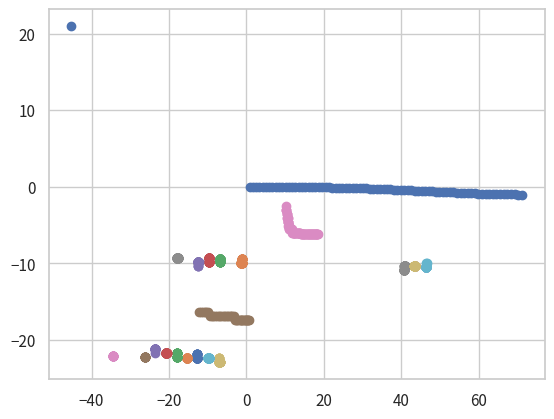

In [42]:
def get_ego_agent_future():
    current_absolute_state = scenario.initial_ego_state

    trajectory_absolute_states = scenario.get_ego_future_trajectory(
        iteration=0, num_samples=num_future_poses, time_horizon=future_time_horizon
    )

    # Get all future poses of the ego relative to the ego coordinate system
    trajectory_relative_poses = convert_absolute_to_relative_poses(
        current_absolute_state.rear_axle, [state.rear_axle for state in trajectory_absolute_states]
    )

    return trajectory_relative_poses

def get_neighbor_agents_future(agent_index):
    current_ego_state = scenario.initial_ego_state
    present_tracked_objects = scenario.initial_tracked_objects.tracked_objects

    # Get all future poses of of other agents
    future_tracked_objects = [
        tracked_objects.tracked_objects
        for tracked_objects in scenario.get_future_tracked_objects(
            iteration=0, time_horizon=future_time_horizon, num_samples=num_future_poses
        )
    ]

    sampled_future_observations = [present_tracked_objects] + future_tracked_objects
    future_tracked_objects_tensor_list, _ = sampled_tracked_objects_to_tensor_list(sampled_future_observations)
    agent_futures = agent_future_process(current_ego_state, future_tracked_objects_tensor_list, num_agents, agent_index)

    return agent_futures

ego_agent_future = get_ego_agent_future()
neighbor_agents_future = get_neighbor_agents_future(neighbor_indices)

print(ego_agent_future.shape)   # shape = (80, 3)
print(neighbor_agents_future.shape)   # shape = (20, 80, 3)

plt.scatter(ego_agent_future[:, 0], ego_agent_future[:, 1])

for i in range(len(neighbor_agents_future)):
    traj = neighbor_agents_future[i]
    x_coords = [point[0] for point in traj if point[0] != 0 or point[1] != 0]
    y_coords = [point[1] for point in traj if point[0] != 0 or point[1] != 0]
    plt.scatter(x_coords, y_coords, label=f'Trajectory {i + 1}')


### gather data

In [43]:
data = {"map_name": map_name, "token": token, "ego_agent_past": ego_agent_past, "ego_agent_future": ego_agent_future,
        "neighbor_agents_past": neighbor_agents_past, "neighbor_agents_future": neighbor_agents_future}
data.update(vector_map)
data.keys()

dict_keys(['map_name', 'token', 'ego_agent_past', 'ego_agent_future', 'neighbor_agents_past', 'neighbor_agents_future', 'lanes', 'crosswalks', 'route_lanes'])

(21, 7) (80, 3)
[5.8207661e-11 0.0000000e+00 7.0479422e-10 8.5574932e+00 2.1650013e-01
 1.5926832e-01 6.6355355e-02] [ 8.2809985e-01  7.1237497e-03 -5.2804995e-04]


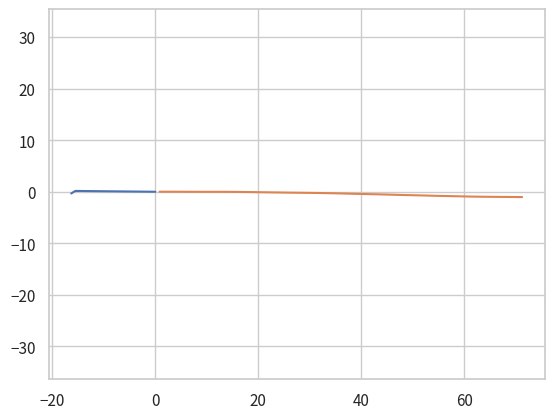

In [44]:
print(ego_agent_past.shape, ego_agent_future.shape)
plt.plot(ego_agent_past[:, 0], ego_agent_past[:, 1])
plt.plot(ego_agent_future[:, 0], ego_agent_future[:, 1])
plt.axis('equal')
print(ego_agent_past[-1, :], ego_agent_future[0, :])

### visualization

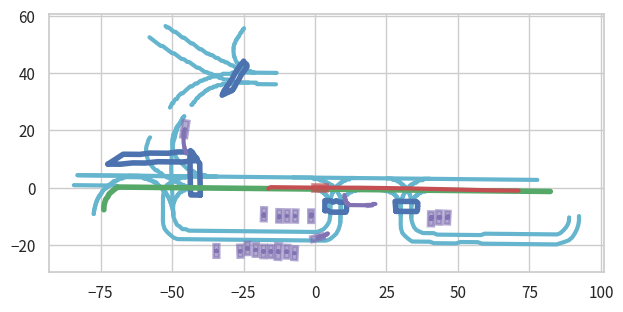

In [45]:
def plot_scenario(data):
    # Create map layers
    create_map_raster(data['lanes'], data['crosswalks'], data['route_lanes'])

    # Create agent layers
    create_ego_raster(data['ego_agent_past'][-1])
    create_agents_raster(data['neighbor_agents_past'][:, -1])

    # Draw past and future trajectories
    draw_trajectory(data['ego_agent_past'], data['neighbor_agents_past'])
    draw_trajectory(data['ego_agent_future'], data['neighbor_agents_future'])

    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()
    
plot_scenario(data)

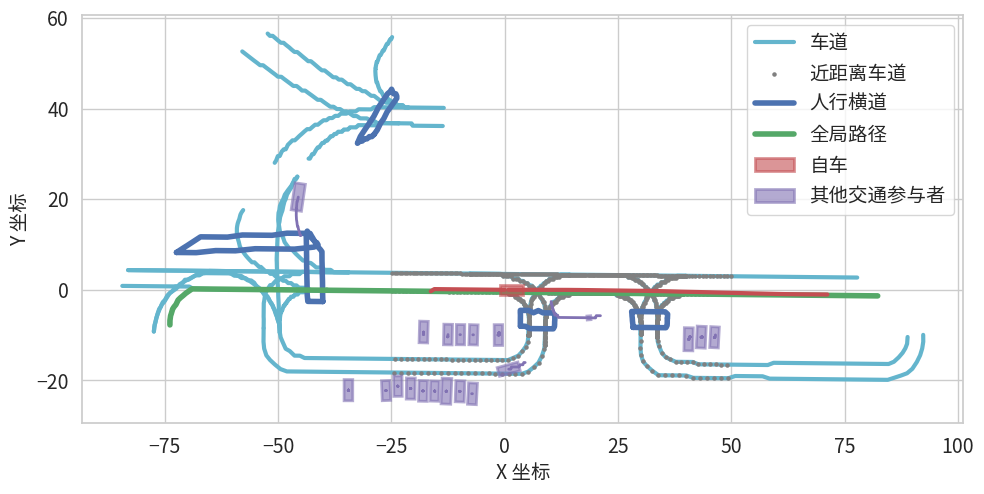

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mpl_transforms

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
def create_map_raster(lanes, crosswalks, route_lanes):
    # 标志变量，用于控制图例标签的添加
    added_label_for_lane = False
    added_label_for_crosswalk = False
    added_label_for_route_lane = False

    for i in range(lanes.shape[0]):
        lane = lanes[i]
        if lane[0][0] != 0:
            if not added_label_for_lane:
                plt.plot(lane[:, 0], lane[:, 1], 'c', linewidth=3, label='车道')  # 为车道中心线添加图例标签
                added_label_for_lane = True
            else:
                plt.plot(lane[:, 0], lane[:, 1], 'c', linewidth=3)

    
    # Scatter points
    lanes = vector_map['lanes'].reshape(-1, 7)
    condition = ((lanes[:, 0] >= -25) & (lanes[:, 0] <= 50)) & ((lanes[:, 1] >= -25) & (lanes[:, 1] <= 25))
    nbr_lanes = lanes[condition]
    plt.scatter(nbr_lanes[:, 0], nbr_lanes[:, 1], c='grey', label='近距离车道', zorder=2, s=5)



    for j in range(crosswalks.shape[0]):
        crosswalk = crosswalks[j]
        if crosswalk[0][0] != 0:
            if not added_label_for_crosswalk:
                plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', linewidth=4, label='人行横道')  # 为人行横道添加图例标签
                added_label_for_crosswalk = True
            else:
                plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', linewidth=4)

    for k in range(route_lanes.shape[0]):
        route_lane = route_lanes[k]
        if route_lane[0][0] != 0:
            if not added_label_for_route_lane:
                plt.plot(route_lane[:, 0], route_lane[:, 1], 'g', linewidth=4, label='全局路径')  # 为路线车道添加图例标签
                added_label_for_route_lane = True
            else:
                plt.plot(route_lane[:, 0], route_lane[:, 1], 'g', linewidth=4)

def create_ego_raster(vehicle_state):
    # 提取自车参数
    vehicle_parameters = get_pacifica_parameters()
    ego_width = vehicle_parameters.width
    ego_front_length = vehicle_parameters.front_length
    ego_rear_length = vehicle_parameters.rear_length

    # 提取自车状态
    x_center, y_center, heading = vehicle_state[0], vehicle_state[1], vehicle_state[2]
    ego_bottom_right = (x_center - ego_rear_length, y_center - ego_width / 2)

    # 绘制矩形以代表自车，并只为自车添加一次标签（使用label参数，但不写字）
    rect = plt.Rectangle(ego_bottom_right, ego_front_length + ego_rear_length, ego_width, linewidth=2, color='r', alpha=0.6, zorder=3, label='自车',
                         transform=mpl_transforms.Affine2D().rotate_around(x_center, y_center, heading) + plt.gca().transData)
    plt.gca().add_patch(rect)


def create_agents_raster(agents):
    # 标志变量，用于控制标签的添加
    added_label_for_agents = False

    for i in range(agents.shape[0]):
        if agents[i, 0] != 0:
            x_center, y_center, heading = agents[i, 0], agents[i, 1], agents[i, 2]
            agent_length, agent_width = agents[i, 6], agents[i, 7]
            agent_bottom_right = (x_center - agent_length/2, y_center - agent_width/2)

            # 为第一个代理车辆添加标签，之后的代理车辆不再添加
            if not added_label_for_agents:
                rect = plt.Rectangle(agent_bottom_right, agent_length, agent_width, linewidth=2, color='m', alpha=0.6, zorder=3, label='其他交通参与者',
                                     transform=mpl_transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData)
                added_label_for_agents = True
            else:
                rect = plt.Rectangle(agent_bottom_right, agent_length, agent_width, linewidth=2, color='m', alpha=0.6, zorder=3,
                                     transform=mpl_transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData)
            
            plt.gca().add_patch(rect)
            
            
def draw_trajectory(ego_trajectory, agent_trajectories):
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], 'r', linewidth=3, zorder=3)

    # plot others
    for i in range(agent_trajectories.shape[0]):
        if agent_trajectories[i, -1, 0] != 0:
            trajectory = agent_trajectories[i]
            plt.plot(trajectory[:, 0], trajectory[:, 1], 'm', linewidth=2, zorder=2)

def plot_scenario(data):
    plt.figure(figsize=(10, 5))
    create_map_raster(data['lanes'], data['crosswalks'], data['route_lanes'])
    create_ego_raster(data['ego_agent_past'][-1])
    create_agents_raster(data['neighbor_agents_past'][:, -1])

    # Draw past and future trajectories
    draw_trajectory(data['ego_agent_past'], data['neighbor_agents_past'])
    draw_trajectory(data['ego_agent_future'], data['neighbor_agents_future'])


    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.legend()
    # plt.show()

plot_scenario(data)
plt.xlabel('X 坐标', fontsize=14)
plt.ylabel('Y 坐标', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'fig/lanes.pdf')

### nuPlan Scenario Visualization

In [101]:
import os
from bokeh.io import output_notebook
from tutorials.utils.tutorial_utils import visualize_nuplan_scenarios, setup_notebook

setup_notebook()
output_notebook()


file_path = f'/data/fyy/GameFormer-Planner/nuplan/dataset/data/cache/train_boston/{log_name}.db'

NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', 'nuplan')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', 'nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', file_path)
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

visualize_nuplan_scenarios(
    data_root=NUPLAN_DATA_ROOT,
    db_files=NUPLAN_DB_FILES,
    map_root=NUPLAN_MAPS_ROOT,
    map_version=NUPLAN_MAP_VERSION,
    bokeh_port=1238,  # This controls the port bokeh uses when generating the visualization -- if you are running
                     # the notebook on a remote instance, you'll need to make sure to port-forward it.
    token=token)   # 这里指定token, 需要修改tutorial_utils.py

Loading BokehJS ...

Dropdown(description='Scenario', options=('accelerating_at_stop_sign', 'accelerating_at_stop_sign_no_crosswalk…

Output()